In [ ]:
import datetime as dt
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import photogrammetry as pg

plt.style.use('seaborn-poster')
# plt.style.use('default')

In [ ]:
importlib.reload(pg)

In [ ]:
# date_dir = dt.date.today().strftime("%Y%m%d")
date_dir = '20220804'

In [ ]:
# check for pickled camera matrices to avoid expensive recalibration
cal_path = os.path.join(date_dir, 'input', 'camera_cal')
if not (
    os.path.exists(os.path.join(cal_path, 'camera_cal_mtx.pickle')) and
    os.path.exists(os.path.join(cal_path, 'camera_cal_dist.pickle')) and
    os.path.exists(os.path.join(cal_path, 'camera_cal_optimal_camera_matrix.pickle'))
):
    # calibrate the camera for distortion
    mtx, dist, optimal_camera_matrix, roi = pg.calibrate_camera(
        os.path.join(date_dir, 'input', 'camera_cal'),
        method='charuco',
        plot=False
    )
    with open(os.path.join(cal_path, 'camera_cal_mtx.pickle'), 'wb') as f:
        pickle.dump(mtx, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(cal_path, 'camera_cal_mtx.pickle'), 'wb') as f:
        pickle.dump(dist, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(cal_path, 'camera_cal_mtx.pickle'), 'wb') as f:
        pickle.dump(optimal_camera_matrix, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(cal_path, 'camera_cal_mtx.pickle'), 'rb') as f:
        mtx = pickle.load(f)
    with open(os.path.join(cal_path, 'camera_cal_dist.pickle'), 'rb') as f:
        dist = pickle.load(f)
    with open(os.path.join(cal_path, 'camera_cal_optimal_camera_matrix.pickle'), 'rb') as f:
        optimal_camera_matrix = pickle.load(f)

In [ ]:
importlib.reload(pg)

run_name = '10x10_0.30x0.30_20220804_r5'
image_data_charuco = pg.find_targets(
    os.path.join(date_dir, 'input', 'meas', run_name),
    os.path.join('targets'),
    mtx,
    dist,
    optimal_camera_matrix,
    stride=1,
    plot=False
)

In [ ]:
%matplotlib widget
importlib.reload(pg)

command_file = os.path.join('..', 'data', 'input', 'profiles', '24in_breadboard_raster_skipline_10x10_0.30x0.30.csv')
os.makedirs(os.path.join(date_dir, 'output', run_name), exist_ok=True)
out_dir = os.path.join(date_dir, 'output', run_name)
commanded_pts, actual_points, residuals = pg.post_process_scan(image_data_charuco, out_dir, command_file, SW_offset=(.05822, .18449))

In [ ]:
importlib.reload(pg)
locs = pg.post_process_SW_reference(image_data_charuco, out_dir)

In [ ]:
# save off processed data:
with open(os.path.join(out_dir, 'image_data.json'), mode='w') as f:
    s = json.dumps(image_data_charuco)
    f.write(s)
with open(os.path.join(out_dir, 'pos_command_data.npy'), mode='wb') as f:
    np.save(f, commanded_pts)
with open(os.path.join(out_dir, 'pos_actual_data.npy'), mode='wb') as f:
    np.save(f, actual_points)
with open(os.path.join(out_dir, 'pos_residual_data.npy'), mode='wb') as f:
    np.save(f, residuals)

In [ ]:
pixel_scales = []
for img, img_data in image_data_charuco.items():
    if os.path.exists(img):
        pixel_scales.append(img_data['px_per_m'] / 1000.)
f = plt.figure()
ax = plt.axes()
ax.hist(pixel_scales, edgecolor='k')
ax.set_xlabel('Pixels per millimeter')
ax.set_ylabel('Counts')
ax.ticklabel_format(axis='x', useOffset=False)
plt.show()

(10, 10, 2)


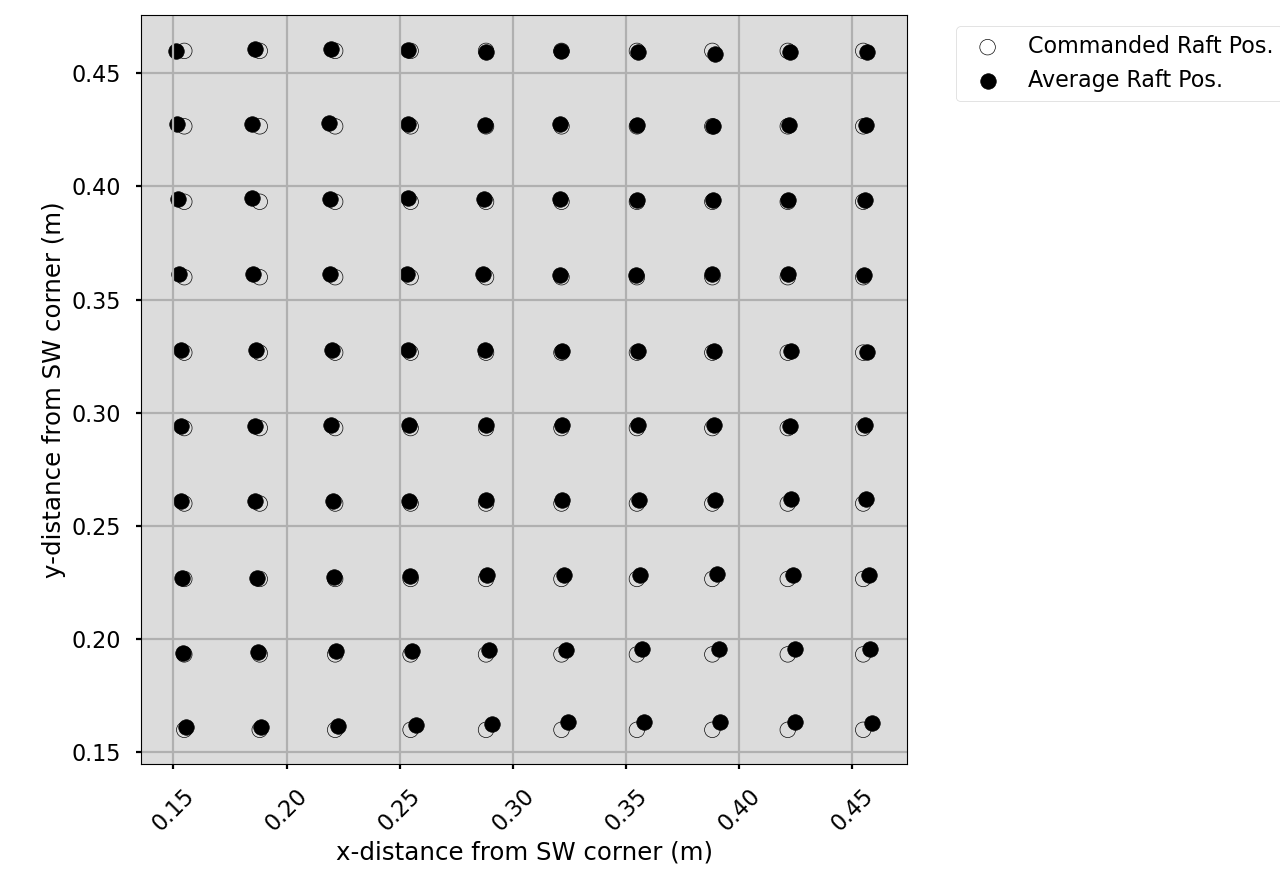

In [90]:
import glob

# Average a few runs:
search_path_actuals = os.path.join(date_dir, '**', 'pos_actual_data.npy')
actuals = glob.glob(search_path, recursive=True)
avg_actuals = np.array([np.load(actual) for actual in actuals]).mean(axis=0)
print(avg_actuals.shape)

f = plt.figure()
ax = plt.axes()
command_data = np.load(os.path.join(os.path.dirname(actuals[0]), 'pos_command_data.npy'))
ax.scatter(command_data[:,:,0], command_data[:,:,1], facecolor='none', edgecolor='k', label='Commanded Raft Pos.', zorder=1)
ax.scatter(avg_actuals[:,:,0], avg_actuals[:,:,1], facecolor='k', label='Average Raft Pos.', zorder=1)
plt.xticks(rotation=45)
ax.set_xlabel('x-distance from SW corner (m)')
ax.set_ylabel('y-distance from SW corner (m)')
ax.grid(True)
ax.set_aspect('equal')
ax.set_facecolor('gainsboro')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplots_adjust(top=0.9)
plt.tight_layout()
# plt.savefig(os.path.join(out_dir, 'avg_pos.png'), facecolor='white', transparent=False)